# Proyecto Integrador M6

🧑🏻‍🍳 Durante el M6 del bootcamp, vimos que para correr un algoritmo de Machine Learning correctamente, debes alimentarlo con un ***dataset limpio***.

<details>
    <summary>📝 <i>Recordatorios sobre el workflow de Procesamiento de datos</i> 📝</summary>

1. 🧭 ***Exploracion y analisis de datos***
2. 👥 Remover ***Duplicados***
3. 🤕 Cambiar o borrar ***Valores faltantes***
4. 🕵🏻‍♂️ Buscar ***Outliers***
5. 📏 ***Escalar*** valores numéricos
6. 🏷 ***One-Hot-Encoder*** Para crear columnas categoricas (muchas columnas, una por categoria)
7. 👻 ***Label-Encoder*** Para crear columnas categoricas (una columna, varios valores, uno por categoria)
8. 🍰 ***Ingenieria de dimensiones*** Feature engineering, crea/elimina columnas con criterio para que tu modelo aprenda mucho mejor
9. 🍰 ***ingenieria de objetivo***: Facilita la predicción para la columna target/label si se le realizan transformaciones.
    
10. ☠️ No todas las caracteristicas son útiles. Elimina las caracteristicas "ruidosas" usando ***Permutacion*** (o ***VIF Analysis*** para modelos lineales)

<u> Notas adicionales</u>    
    
- _Ejemplo de ingenieria de dimensiones: Si tu tienes el largo y el ancho de un departamento, podrias sacar la superficie total multiplicando el largo por el ancho_

- _Ejemplo de ingenieria de objetivo: Si buscas predecir el precio de una accion en el proximo dia, puede ser mas facil predecir el %incremento que el valor absoluto. Si buscas precios de casas, es posible que quieras predecir el logaritmo de sus valores y, a continuacion, exponenciar las predicciones_

- Por caracteristicas "ruidosas", nos referimos a:
    - o bien una caracteristica que no aporta nada a la prediccion en el sentido de que cuando se elimina esta caracteristica, no afecta a la performance del modelo
    - o una caracteristica que es construida usando a otras (fuerte relacion lineal)
    
</details>

 El objetivo de este template es construir un pipeline optimo para ***predecir el precio de los autos de acuerdo con sus especificaciones***:

1. Vamos a necesitar un *pipeline de procesos*...
2. ... con eso podemos *concatenar con un modelo de Sickit-Learn*
3. y luego ir mas alla con:
    - hacer una *FeaturePermutation*
    - optimizar los hiperparametros con un *GridSearchCV* o un *RandomizedSearchCV*

In [3]:
# MANIPULACION DE LA DATA
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None) # MUESTRA TODAS LAS COLUNAS DE UN PANDAS DATAFRAME

# VISUALIZACION DE DATOS
import matplotlib.pyplot as plt
import seaborn as sns

import warnings # Sacamos los warnings de las salidas del notebook
warnings.filterwarnings("ignore")

# ESTADISTICAS
from statsmodels.graphics.gofplots import qqplot
# Esta funcion compara la distribucion de la muestra con una distribucion normal, 
# para comprobar si tu muestra se distribuye normalmente o no.

## (1) El dataset

Cargamos el dataset y eliminamos la columna con el id, ya que no tiene sentido alimentar un algoritmo de ML con un id, no ofrece nada de correlación real y podríamos estar colocando sesgo a nuestro modelo, dificultando el fitting.

In [4]:
cars = pd.read_csv("/ML_cars.csv")
cars.drop(columns = ['car_ID'], inplace = True) # Eliminamos la columna 'car_ID'
cars.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### (1.1) Información Básica

❓ Cuantos autos (carros) tenemos ❓

In [5]:
print(f"Hay {cars.shape[0]} carros en el dataset")

Hay 205 carros en el dataset


❓ Inspección de los tipos de las columnas ❓

In [6]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

### Requisitos previos

#### Anomalias en el dataset

Si miramos a las columnas con el tipo de dato *object*, podés ver qué columnas podrian/deberian ser convertidas a columnas tipo numéricas.

Debemos convierlas a categóricas.

* La columna _cylindernumber_ claramente necesita ser convertida a un tipo numérico
* En cuanto a _doornumber_, es a consideracion particular pero nosotros pensamos que podemos conservar el valor como columna categorica porque la mayoria de los autos tienen entre dos o cuatro puertas, ni una, ni tres o ni cinco!


In [7]:
cars["cylindernumber"] = cars["cylindernumber"].map({"four":4,
                                                 "six":6,
                                                 "five":5,
                                                 "eight":8,
                                                 "two":2,
                                                 "twelve":12,
                                                 "three":3})

In [8]:
cars["doornumber"].value_counts() # Solo 2 o 4 puertas

four    115
two      90
Name: doornumber, dtype: int64

#### Removiendo duplicados

Cuantas filas duplicadas tenemos en este dataset??? (de haber, las sacamos!)

In [9]:
print(f"Numero de filas duplicadas = {cars.duplicated().sum()}")
print("-"*50)

print(f"filas/columnas del dataset de carros antes de eliminar los duplicados = {cars.shape}")
print("-"*50)

cars.drop_duplicates(inplace = True)
print(f"filas/columnas del dataset de carros despues de eliminar los duplicados = {cars.shape}")

Numero de filas duplicadas = 0
--------------------------------------------------
filas/columnas del dataset de carros antes de eliminar los duplicados = (205, 25)
--------------------------------------------------
filas/columnas del dataset de carros despues de eliminar los duplicados = (205, 25)


#### Manejo de valores faltantes

Cuantos NaN tenemos?

In [ ]:
cars.isna().sum()

symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

<details>
    <summary><i>Respuesta</i></summary>

* No hay Nan, es un milagro 😇 
* Si tienes mas del 30% de valores faltantes en una fila/columna, eliminala 🚮
* De lo contrario, podrias usar a *SimpleImputer* o un *KNN Imputer* para darle valor a esos faltantes😉
    
</details>

### Echando un vistazo a  (`cars' price`)

Cómo es su objetivo en cuanto a  _Distribucion_, _Outliers_, _Gaussianidad_ 

```python
variable = 'price'
y = cars[f"{variable}"]

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribucion de:  {variable}")
sns.histplot(data = cars, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot de: {variable}")
sns.boxplot(data = cars, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Gaussianidad de: {variable}")
qqplot(cars[f"{variable}"],line='s',ax=ax[2]);    
```
    
- Este histograma junto a la densidad estimada nos muestra que ***la distribucion de los precios es bastante sesgada y no gaussiana***
- El grafico de boxplot nos indica unos potenciales outliers. Deberias checkear esos valores, y ver, que esos son solo autos mucho mas caros. Pero ninguno de esos valores parece estar fuera de rango, como un falsa medicion, etcetera...! #Conocimientos particulares del problema!
- El QQ-plot es otra prueba que la distribucion de precios no es gaussiana: 
    - Recuerda que los puntos de dispersion de tu señal deben coincidir estrechamente con $ y = x $,  si la señal tiene una distribucion gaussiana.



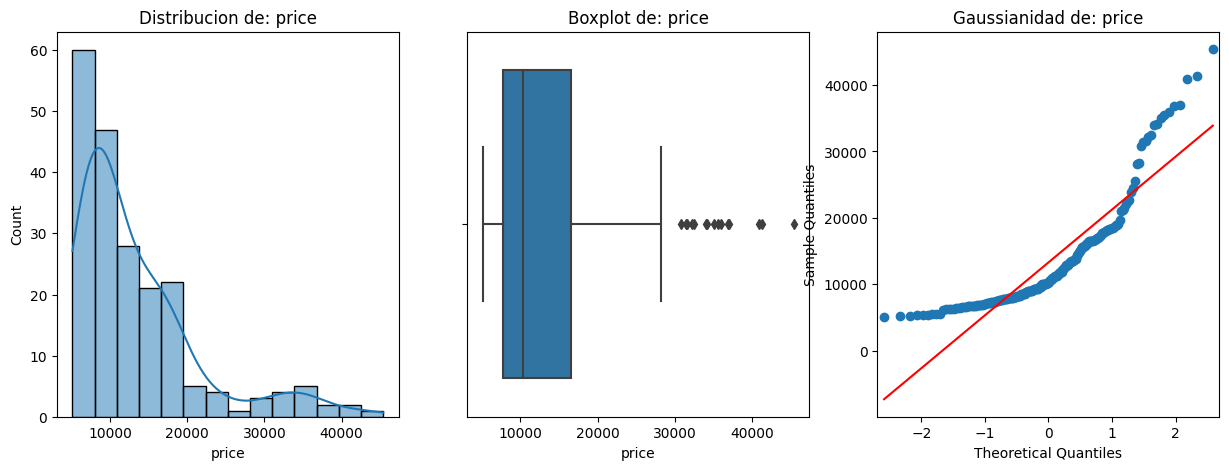

In [13]:
variable = 'price'
y = cars[f"{variable}"]

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribucion de: {variable}")
sns.histplot(data = cars, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot de: {variable}")
sns.boxplot(data = cars, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Gaussianidad de: {variable}")
qqplot(cars[f"{variable}"],line='s',ax=ax[2]);

In [14]:
cars.skew()

C:\Users\Gonzalo Posse\AppData\Local\Temp\ipykernel_6136\3141738871.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cars.skew()


symboling           0.211072
wheelbase           1.050214
carlength           0.155954
carwidth            0.904003
carheight           0.063123
curbweight          0.681398
cylindernumber      2.817459
enginesize          1.947655
boreratio           0.020156
stroke             -0.689705
compressionratio    2.610862
horsepower          1.405310
peakrpm             0.075159
citympg             0.663704
highwaympg          0.539997
price               1.777678
dtype: float64

## Procesar las caracteristicas con un Pipeline

Tenemos un vistazo general de la distribucion de los carros. 

Es hora de construir un _pipeline de pre-procesamiento_ que, humildemente, llamaremos _preprocesador_.

Como lidiar con la columna <i>CarName</i> para predecir el valor de un carro ? 

Podriamos extraer la marca del vehículo de `CarName` usando tecnicas de *expresiones regulares*, o usar `NLP` para extraer esa información. En nuestro caso, vamos a ignorar el `CarName` para predecir el precio por el momento.
    


In [15]:
X = cars.drop(columns = ["price", "CarName"])

In [16]:
# PIPELINE Y TRANSFORMADOR DE COLUMNAS
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display="diagram")  

# IMPUTERS
from sklearn.impute import SimpleImputer

# SCALERS
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# ENCODER
from sklearn.preprocessing import OneHotEncoder

### Pipeline para lidiar con datos numericos

Es buena idea optimizar el trabajo de los algoritmos tratando los datos numéricos, se pueden escalar, estandarizar o normalizar, manteniendo su varianza pero haciéndolos más eficientes de procesar para los algoritmos de los modelos, reduciendo el sesgo que puedan provocar valores outliers.

Almacenamos las caracteristicas numericas en una variable `X_num`

In [17]:
X_num = X.select_dtypes(exclude = ['object'])
X_num.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,3,88.6,168.8,64.1,48.8,2548,4,130,3.47,2.68,9.0,111,5000,21,27
1,3,88.6,168.8,64.1,48.8,2548,4,130,3.47,2.68,9.0,111,5000,21,27
2,1,94.5,171.2,65.5,52.4,2823,6,152,2.68,3.47,9.0,154,5000,19,26
3,2,99.8,176.6,66.2,54.3,2337,4,109,3.19,3.40,10.0,102,5500,24,30
4,2,99.4,176.6,66.4,54.3,2824,5,136,3.19,3.40,8.0,115,5500,18,22


Creamos un pipeline `num_transformer_simplified` para lidiar con las caracteristícas numéricas 

Artículo de referencia para Scalers <a href="https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02"> Escalar,Estandarizar o Normalizar con Scikit-Learn</a> escrito por: Jeff Hale    


***SOLUCION MINIMA CON SOLO UN SCALER***

In [18]:
num_transformer_simplified = make_pipeline(
                    SimpleImputer(strategy = "median"), # Usamos la estrategia de imputar con la mediana.
                    RobustScaler() # Robust scaler permite escalar los datos sin ser muy afectado por outliers.
                )

num_transformer_simplified

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('robustscaler', RobustScaler())])

In [19]:
pd.DataFrame(num_transformer_simplified.fit_transform(X_num), columns=X_num.columns).head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,1.0,-1.063291,-0.261905,-0.500000,-1.514286,0.169620,0.0,0.227273,0.372093,-2.033333,0.00,0.347826,-0.285714,-0.272727,-0.333333
1,1.0,-1.063291,-0.261905,-0.500000,-1.514286,0.169620,0.0,0.227273,0.372093,-2.033333,0.00,0.347826,-0.285714,-0.272727,-0.333333
2,0.0,-0.316456,-0.119048,0.000000,-0.485714,0.517722,2.0,0.727273,-1.465116,0.600000,0.00,1.282609,-0.285714,-0.454545,-0.444444
3,0.5,0.354430,0.202381,0.250000,0.057143,-0.097468,0.0,-0.250000,-0.279070,0.366667,1.25,0.152174,0.428571,0.000000,0.000000
4,0.5,0.303797,0.202381,0.321429,0.057143,0.518987,1.0,0.363636,-0.279070,0.366667,-1.25,0.434783,0.428571,-0.545455,-0.888889


***SOLUCION USANDO TRES SCALERS DISTINTOS***

Primero, verificamos la distribución de los datos en cada columna para poder elegir mejos cuáles scalers usar, algunos, como RobustScaler escalan muy bien datos con outliers, para los que tienen distribución normal, es mejor usar StandardScaler y para los que se manejan por un rango muy definido con un valor máximo y otro mínimo, donde sabes que no hay valores menores o mayores a esos límites, es mejor usar MinMaxScaler.

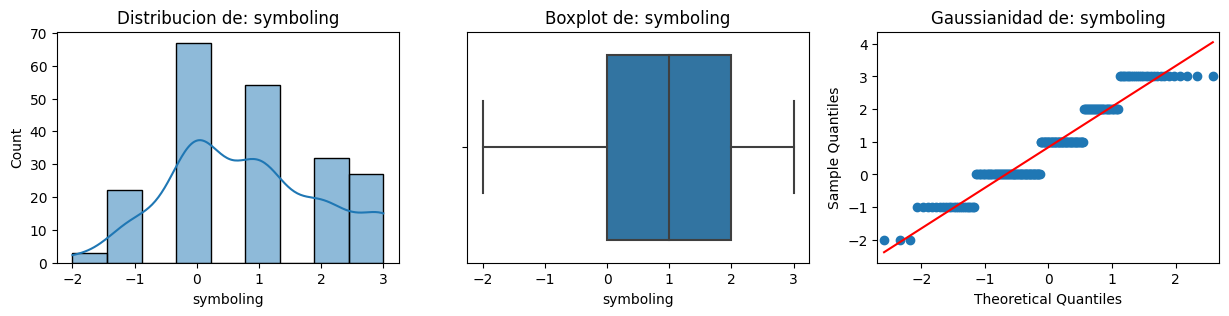

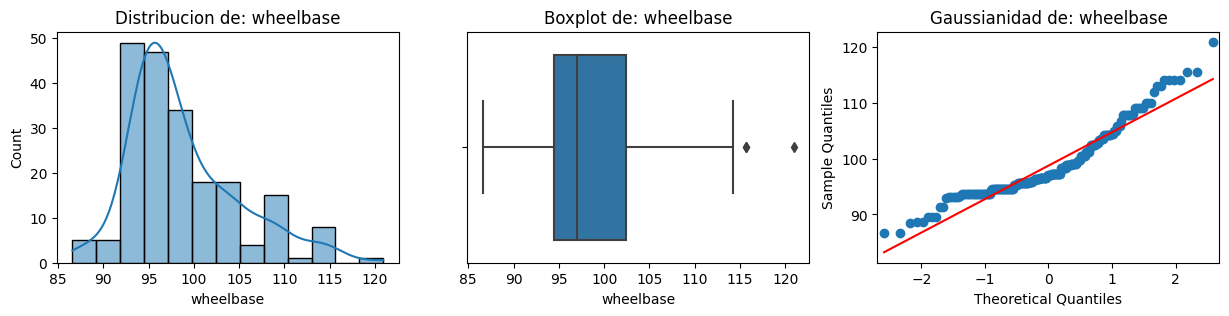

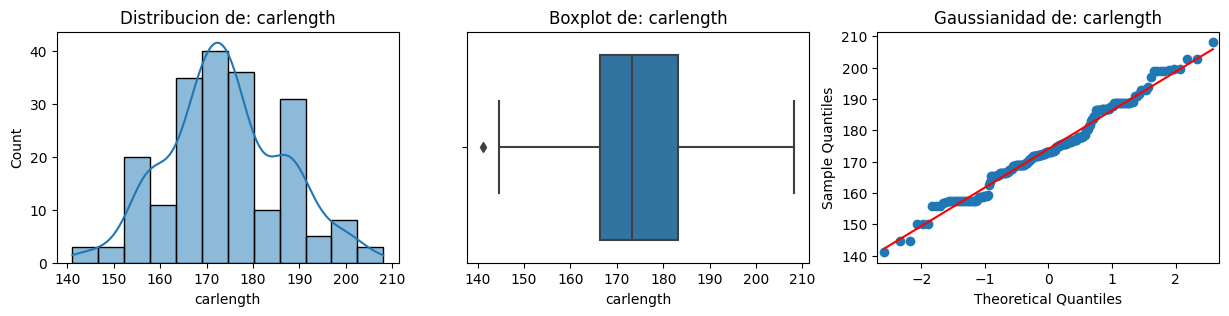

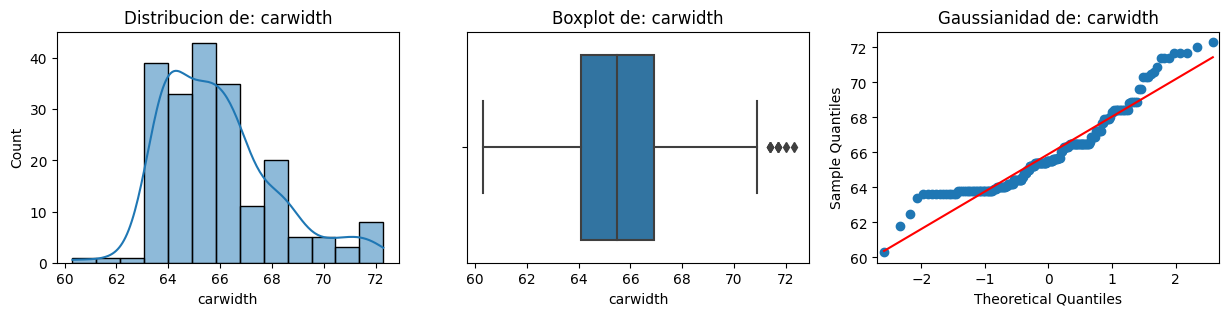

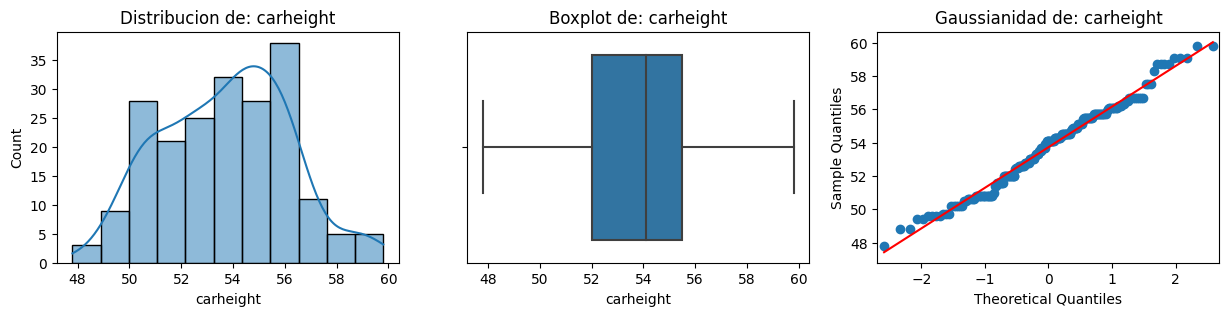

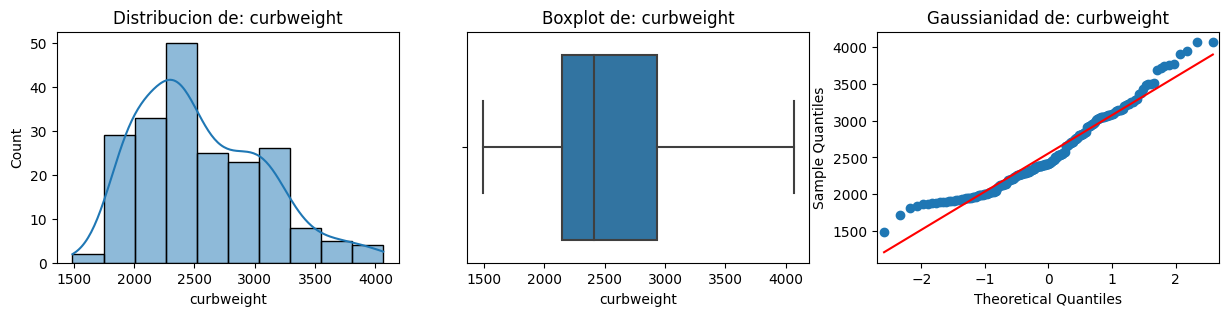

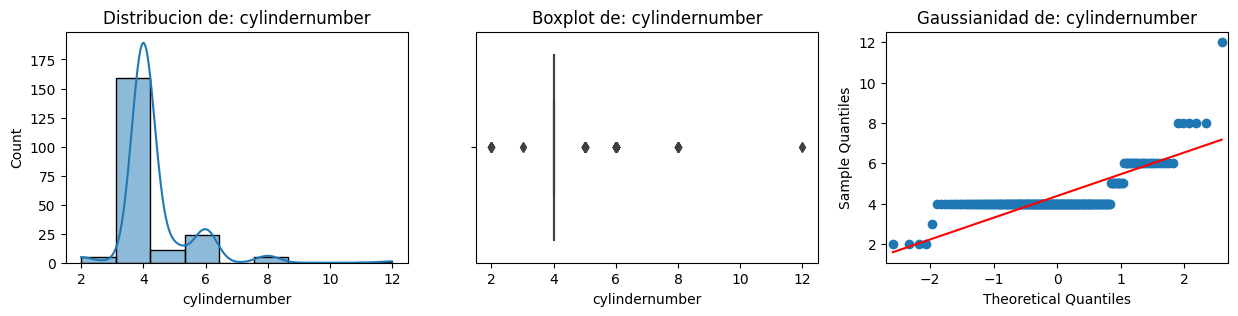

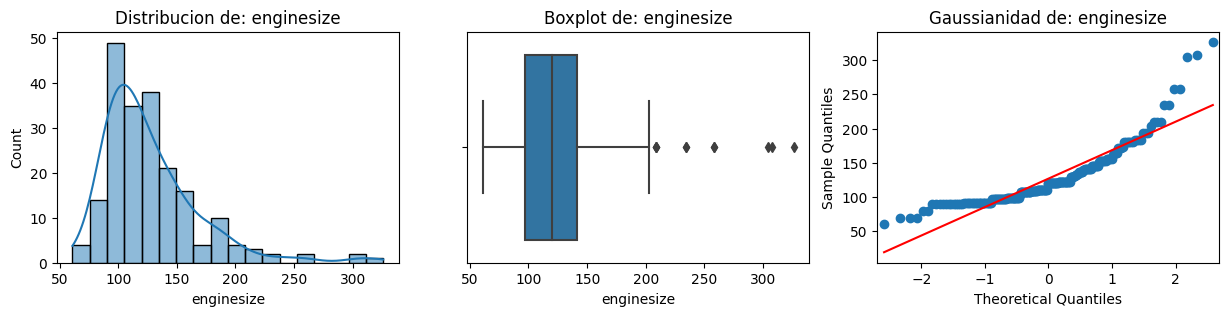

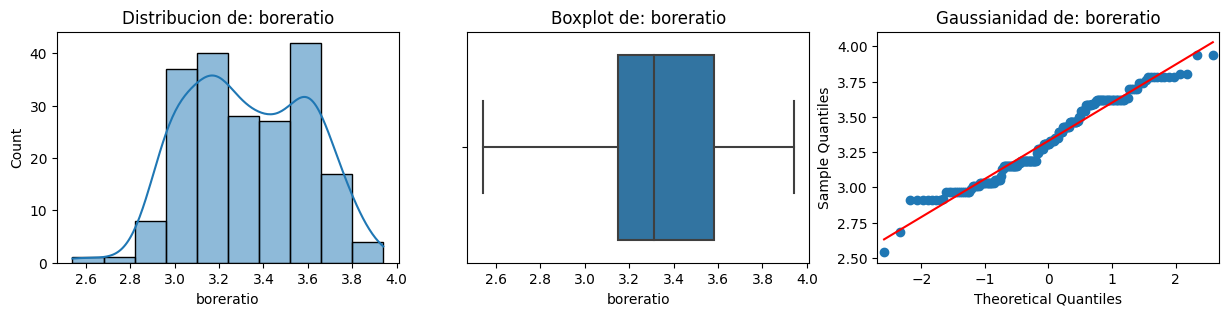

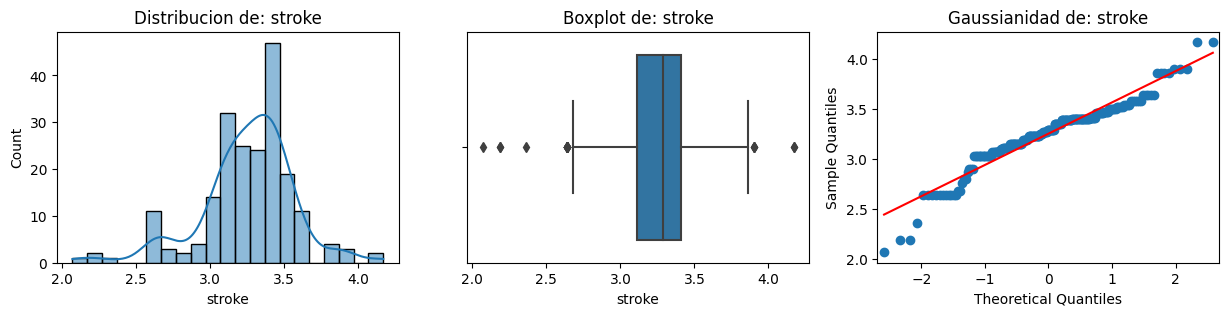

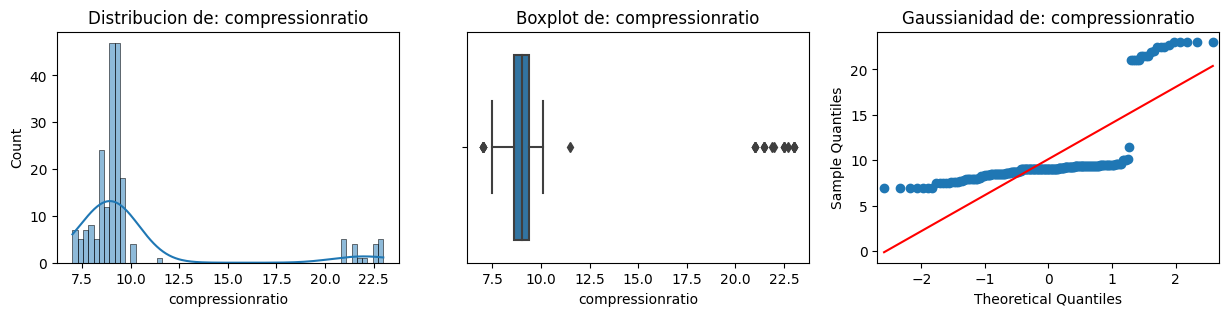

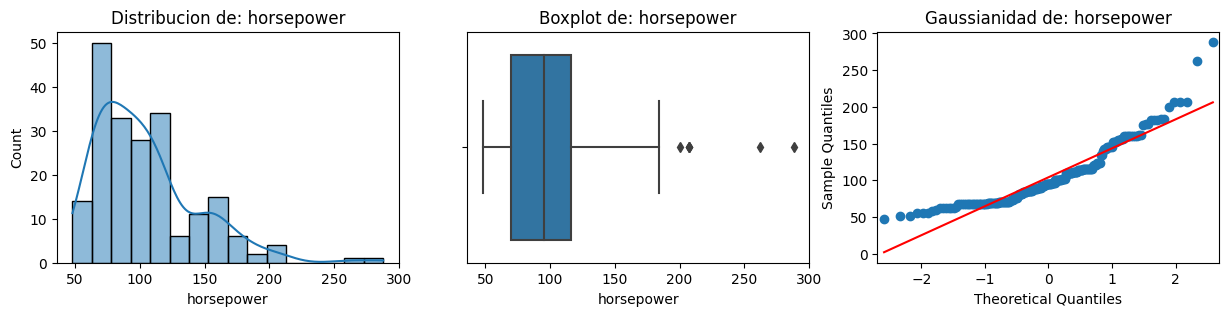

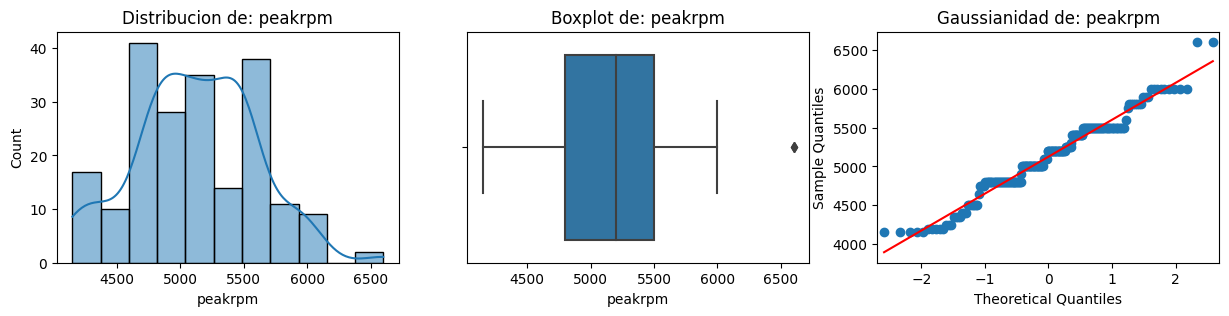

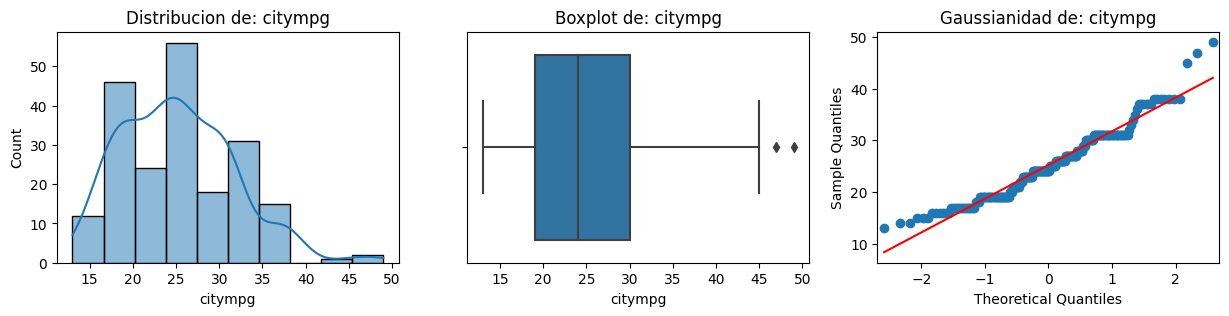

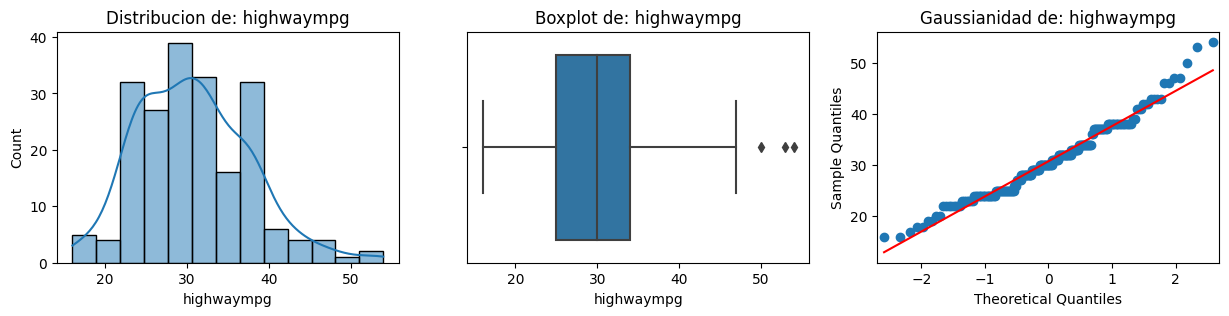

In [20]:
for numerical_feature in X_num.columns:
    
    # Creacion de tres subplots por cada caracteristica_numerica
    fig, ax =plt.subplots(1,3,figsize=(15,3))
    
    # Histograma para tener un vistazo de la distribucion de cada caracteristica_numerica
    ax[0].set_title(f"Distribucion de: {numerical_feature}")
    sns.histplot(data = X_num, x = numerical_feature, kde=True, ax = ax[0])
    
    # Boxplot para detectar outliers
    ax[1].set_title(f"Boxplot de: {numerical_feature}")
    sns.boxplot(data = X_num, x = numerical_feature, ax=ax[1])
    
    # Analizar si una caracteristica se distribuye normalmente o no
    ax[2].set_title(f"Gaussianidad de: {numerical_feature}")
    qqplot(X_num[numerical_feature],line='s',ax=ax[2]);

Siguiendo las distribuciones mostradas arriba, las columnas con varios outliers, serán tratadas con RobustScaler ("cylindernumber", "enginesize", "stroke", "compressionratio", "horsepower"). Las que siguen distribuciones bastante normales ("symboling", "wheelbase", "carlength", "carwidth", "carheight","curbweight", "boreratio", "highwaympg") usarán StandardScaler y las que se manejan en un rango muy definido ("peakrpm", "citympg") usarán MinMaxScaler. Armamos listas siguiendo estas directivas.

In [21]:
features_robust = ["cylindernumber", "enginesize", "stroke", "compressionratio", "horsepower"]
features_standard = ["symboling", "wheelbase", "carlength", "carwidth", "carheight","curbweight", "boreratio", "highwaympg"]
features_minmax = ["peakrpm", "citympg"]
features_already_scaled = []

In [22]:
# Checkeando que no nos olvidamos ninguna caracteristica numerica
X_num.shape[-1] == len(features_robust + features_standard + features_minmax + features_already_scaled)

True

Vamos a utilizar un ColumnTransformer (transformador de columna) que simplemente llamaremos `scalers` para utilizar tres scalers diferentes en las caracteristicas numericas a escalar:

In [23]:
scalers = ColumnTransformer(
                                [
                                    ("robust_scaler", RobustScaler(), features_robust),
                                    ("standard_scaler", StandardScaler(), features_standard),
                                    ("minmax_scaler", MinMaxScaler(), features_minmax)
                                ])

Ahora, vamos a encadenar un *SimpleImputer* con este mini pipeline `scalers` para crear un nuevo Pipeline llamado `num_transformer`

In [24]:
num_transformer = make_pipeline(
                    SimpleImputer(strategy = "median"),                    
                    scalers
                )

num_transformer

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('columntransformer',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['cylindernumber',
                                                   'enginesize', 'stroke',
                                                   'compressionratio',
                                                   'horsepower']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['symboling', 'wheelbase',
                                                   'carlength', 'carwidth',
                                                   'carheight', 'curbweight',
                                                   'boreratio', 'highwaympg']),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(),
                                                  ['peakrpm', 'citympg'])]))])

Intentamos aplicar `num_transformer` en `X_num`, pero no funciona!

In [25]:
# X_num_scaled = pd.DataFrame(num_transformer.fit_transform(X_num))
# X_num_scaled.head()

Por que no funciona? `scalers` es un ColumnTransformer que necesita los nombres de las columnas... Desafortunadamente, tras colocar un Imputer, desaparecieron!


Necesitamos crear un `imputer_with_name` 

In [26]:
# OPCION 1) Introducimos una nueva clase `ColumnNameExtractor` para conservar los nombres de las columnas despues del `SimpleImputer`
from sklearn.base import BaseEstimator, TransformerMixin


class  ColumnNameExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, *_):
        return self

    def transform(self, X, *_):
        return pd.DataFrame(X, columns = self.columns)
    
    def fit_transform(self, X, *_):
        return pd.DataFrame(X, columns = self.columns)
    
imputer_with_name = make_pipeline(
    SimpleImputer(strategy="median"),
    ColumnNameExtractor(features_robust + features_standard + features_minmax +
                        features_already_scaled),
)

pd.DataFrame(imputer_with_name.fit_transform(X_num)).head()

,cylindernumber,enginesize,stroke,compressionratio,horsepower,symboling,wheelbase,carlength,carwidth,carheight,curbweight,boreratio,highwaympg,peakrpm,citympg
0,3.0,88.6,168.8,64.1,48.8,2548.0,4.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0
1,3.0,88.6,168.8,64.1,48.8,2548.0,4.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0
2,1.0,94.5,171.2,65.5,52.4,2823.0,6.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0
3,2.0,99.8,176.6,66.2,54.3,2337.0,4.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0
4,2.0,99.4,176.6,66.4,54.3,2824.0,5.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0


In [27]:
# OPCION 2) MODIFICAR LA CLASE DE SIMPLE IMPUTER  SimpleImputer no tiene la funcion get_feature_names_out, asi que necesitamos añadirla manualmente.

class CustomSimpleImputer(SimpleImputer):
    def fit(self, X, *args, **kwargs):
        self.columns = X.columns
        return super().fit(X, *args, **kwargs) 
    
    def transform(self, *args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.columns)
    
    def fit_transform(self, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.columns)

imputer_with_name = CustomSimpleImputer(strategy='median')

pd.DataFrame(imputer_with_name.fit_transform(X_num)).head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,3.0,88.6,168.8,64.1,48.8,2548.0,4.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0
1,3.0,88.6,168.8,64.1,48.8,2548.0,4.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0
2,1.0,94.5,171.2,65.5,52.4,2823.0,6.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0
3,2.0,99.8,176.6,66.2,54.3,2337.0,4.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0
4,2.0,99.4,176.6,66.4,54.3,2824.0,5.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0


In [28]:
# OPCION 3) sustituimos la clase existente

from sklearn.impute import SimpleImputer
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)
imputer_with_name = SimpleImputer(strategy='median')
pd.DataFrame(imputer_with_name.fit_transform(X_num), columns = imputer_with_name.get_feature_names_out())

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,3.0,88.6,168.8,64.1,48.8,2548.0,4.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0
1,3.0,88.6,168.8,64.1,48.8,2548.0,4.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0
2,1.0,94.5,171.2,65.5,52.4,2823.0,6.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0
3,2.0,99.8,176.6,66.2,54.3,2337.0,4.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0
4,2.0,99.4,176.6,66.4,54.3,2824.0,5.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1.0,109.1,188.8,68.9,55.5,2952.0,4.0,141.0,3.78,3.15,9.5,114.0,5400.0,23.0,28.0
201,-1.0,109.1,188.8,68.8,55.5,3049.0,4.0,141.0,3.78,3.15,8.7,160.0,5300.0,19.0,25.0
202,-1.0,109.1,188.8,68.9,55.5,3012.0,6.0,173.0,3.58,2.87,8.8,134.0,5500.0,18.0,23.0
203,-1.0,109.1,188.8,68.9,55.5,3217.0,6.0,145.0,3.01,3.40,23.0,106.0,4800.0,26.0,27.0


Ahora podemos usar Imputer y Column Transformer

In [29]:
num_transformer = make_pipeline(
                    CustomSimpleImputer(strategy='median'),
                    ColumnTransformer(
                                [
                                    ("robust_scaler", RobustScaler(), features_robust),
                                    ("standard_scaler", StandardScaler(), features_standard),
                                    ("minmax_scaler", MinMaxScaler(), features_minmax)
                                ])
                )

num_transformer.fit(X_num)
num_transformer.transform(X_num)

array([[ 0.        ,  0.22727273, -2.03333333, ..., -0.54605874,
         0.34693878,  0.22222222],
       [ 0.        ,  0.22727273, -2.03333333, ..., -0.54605874,
         0.34693878,  0.22222222],
       [ 2.        ,  0.72727273,  0.6       , ..., -0.69162706,
         0.34693878,  0.16666667],
       ...,
       [ 2.        ,  1.20454545, -1.4       , ..., -1.12833203,
         0.55102041,  0.13888889],
       [ 2.        ,  0.56818182,  0.36666667, ..., -0.54605874,
         0.26530612,  0.36111111],
       [ 0.        ,  0.47727273, -0.46666667, ..., -0.83719538,
         0.51020408,  0.16666667]])

El transformador de columnas perdio los nombres otra vez: Mantengamos los nombres de las columnas tambien con un CustomColumnTransformer

In [30]:
# -------------------------------------------------- #
#      TRANSFORMADOR DE COLUMNAS PERSONALIZADO       #
# -------------------------------------------------- #
# Armamos una clase para guardar los nombres de las columnas antes de entrenar un modelo

class CustomColumnTransformer(ColumnTransformer):
    
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs)
    
    def transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().transform(X, *args, **kwargs), columns=self.get_feature_names_out())
    
    def fit_transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(X, *args, **kwargs), columns=self.get_feature_names_out())

In [31]:
num_transformer = make_pipeline(
                    CustomSimpleImputer(strategy = "median"),
                    CustomColumnTransformer(
                                [
                                    ("robust_scaler", RobustScaler(), features_robust),
                                    ("standard_scaler", StandardScaler(), features_standard),
                                    ("minmax_scaler", MinMaxScaler(), features_minmax)
                                ])
                )

num_transformer.fit(X_num)
num_transformer.transform(X_num)
num_transformer.fit_transform(X_num)

,robust_scaler__cylindernumber,robust_scaler__enginesize,robust_scaler__stroke,robust_scaler__compressionratio,robust_scaler__horsepower,standard_scaler__symboling,standard_scaler__wheelbase,standard_scaler__carlength,standard_scaler__carwidth,standard_scaler__carheight,standard_scaler__curbweight,standard_scaler__boreratio,standard_scaler__highwaympg,minmax_scaler__peakrpm,minmax_scaler__citympg
0,0.0,0.227273,-2.033333,0.000,0.347826,1.743470,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.519071,-0.546059,0.346939,0.222222
1,0.0,0.227273,-2.033333,0.000,0.347826,1.743470,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.519071,-0.546059,0.346939,0.222222
2,2.0,0.727273,0.600000,0.000,1.282609,0.133509,-0.708596,-0.231513,-0.190566,-0.543527,0.514882,-2.404880,-0.691627,0.346939,0.166667
3,0.0,-0.250000,0.366667,1.250,0.152174,0.938490,0.173698,0.207256,0.136542,0.235942,-0.420797,-0.517266,-0.109354,0.551020,0.305556
4,1.0,0.363636,0.366667,-1.250,0.434783,0.938490,0.107110,0.207256,0.230001,0.235942,0.516807,-0.517266,-1.273900,0.551020,0.138889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.0,0.477273,-0.466667,0.625,0.413043,-1.476452,1.721873,1.198549,1.398245,0.728239,0.763241,1.666445,-0.400490,0.510204,0.277778
201,0.0,0.477273,-0.466667,-0.375,1.413043,-1.476452,1.721873,1.198549,1.351515,0.728239,0.949992,1.666445,-0.837195,0.469388,0.166667
202,2.0,1.204545,-1.400000,-0.250,0.847826,-1.476452,1.721873,1.198549,1.398245,0.728239,0.878757,0.926204,-1.128332,0.551020,0.138889
203,2.0,0.568182,0.366667,17.500,0.239130,-1.476452,1.721873,1.198549,1.398245,0.728239,1.273437,-1.183483,-0.546059,0.265306,0.361111


### Pipeline para columnas categoricas

Guardamos las columnas categoricas en una variable llamada `cars_cat`

In [32]:
X_cat = X.select_dtypes(include=['object'])
X_cat.head()

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,fuelsystem
0,gas,std,two,convertible,rwd,front,dohc,mpfi
1,gas,std,two,convertible,rwd,front,dohc,mpfi
2,gas,std,two,hatchback,rwd,front,ohcv,mpfi
3,gas,std,four,sedan,fwd,front,ohc,mpfi
4,gas,std,four,sedan,4wd,front,ohc,mpfi


In [33]:
cat_features = list(X_cat.columns)
cat_features

['fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'fuelsystem']

Checkear con cuantas columnas terminas, si decides hacer One Hot Encode a todas las columnas categóricas. Verificar que sea un número razonable y que no llenemos de columnas al dataset innecesariamente.




In [37]:
unique_occurences = {cat_feature:
                                 len(X_cat[cat_feature].value_counts()) 
                                 for cat_feature in X_cat.columns}

unique_occurences = pd.DataFrame.from_dict(unique_occurences,
                                                       orient = "index",
                                                       columns = ["unique_occurences"])

unique_occurences = unique_occurences.sort_values(by = "unique_occurences",
                                                  ascending = False)

In [38]:
print(unique_occurences)

                unique_occurences
fuelsystem                      8
enginetype                      7
carbody                         5
drivewheel                      3
fueltype                        2
aspiration                      2
doornumber                      2
enginelocation                  2


In [39]:
multiple_cat = list(unique_occurences[unique_occurences.unique_occurences > 2].index)
multiple_cat

['fuelsystem', 'enginetype', 'carbody', 'drivewheel']

In [40]:
binary_cat = list(unique_occurences[unique_occurences.unique_occurences <= 2].index)
binary_cat

['fueltype', 'aspiration', 'doornumber', 'enginelocation']

In [42]:
columns_generated_by_multiple_ohe = unique_occurences.loc[multiple_cat].sum()[0]
columns_generated_by_binary_ohe = len(binary_cat)
columns_ohe = columns_generated_by_multiple_ohe + columns_generated_by_binary_ohe



print(f"Si vamos a hacer One-Hot-Encode a todas las columnas categoricas de este dataset de autos/carros, vamos a generar {columns_generated_by_multiple_ohe} + {columns_generated_by_binary_ohe} = {columns_ohe} columnas")

Si vamos a hacer One-Hot-Encode a todas las columnas categoricas de este dataset de carros, vamos a generar 23 + 4 = 27 columnas


Creamos un pipeline, `cat_transformer` para lidiar con caracteristicas categoricas, usando SimpleImputer (con la estrategia de los más frecuentes, para rellenar los datos con el mas frecuente en el dataset) y OneHotEncoder para crear las columnas categóricas.

In [43]:
cat_transformer = make_pipeline(
                    SimpleImputer(strategy = "most_frequent"),
                    OneHotEncoder(sparse = False, handle_unknown = "ignore", drop='if_binary')
                )

cat_transformer

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse=False))])

Hacemos un  .fit_transform_ a con nuestro pipeline `cat_transformer` en `X_cat`

In [44]:
X_cat_encoded = pd.DataFrame(cat_transformer.fit_transform(X_cat))
X_cat_encoded

c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
201,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
202,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
203,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Usamos OneHotEncoder para crear las columnas categóricas, creando nuestro pipeline para crear columnas categóricas, `cat_transformer`.

In [45]:
# Creamos nuestra clase One-Hot-Encoder que pasa los nombres de las columnas en categóricas.
from sklearn.preprocessing import OneHotEncoder

class CustomOHE(OneHotEncoder):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

cat_transformer = make_pipeline(
                    CustomSimpleImputer(strategy = "most_frequent"),
                    CustomOHE(sparse = False, handle_unknown = "ignore", drop='if_binary')
                )
X_cat_encoded = pd.DataFrame(cat_transformer.fit_transform(X_cat))
X_cat_encoded.shape # Verificamos el número de filas y columnas para chequear que funcione.

c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(205, 27)

### Pre-procesamiento

Creamos el pipeline para preprocesar nuestros datos `preprocessor` que combina `num_transformer` (para pasar a columna numérica) y `cat_transformer` (para pasar a columna categórica) en un solopipeline.

In [46]:
preprocessor = make_pipeline(
                CustomColumnTransformer([
                    ("num_transformer", num_transformer, make_column_selector(dtype_include = ["float64","int64"])),
                    ("cat_transformer", cat_transformer, make_column_selector(dtype_include = "object"))
                    ])
                )

preprocessor

Pipeline(steps=[('customcolumntransformer',
                 CustomColumnTransformer(transformers=[('num_transformer',
                                                        Pipeline(steps=[('customsimpleimputer',
                                                                         CustomSimpleImputer(strategy='median')),
                                                                        ('customcolumntransformer',
                                                                         CustomColumnTransformer(transformers=[('robust_scaler',
                                                                                                                RobustScaler(),
                                                                                                                ['cylindernumber',
                                                                                                                 'enginesize',
                                                                                                                 'stroke',
                                                                                                                 'compressionratio',
                                                                                                                 'horsepower']),...
                                                        <sklearn.compose._column_transformer.make_column_selector object at 0x00000221F9DCC9D0>),
                                                       ('cat_transformer',
                                                        Pipeline(steps=[('customsimpleimputer',
                                                                         CustomSimpleImputer(strategy='most_frequent')),
                                                                        ('customohe',
                                                                         CustomOHE(drop='if_binary',
                                                                                   handle_unknown='ignore',
                                                                                   sparse=False,
                                                                                   sparse_output=False))]),
                                                        <sklearn.compose._column_transformer.make_column_selector object at 0x00000221F9DCD750>)]))])

Hacemos fit_transform_  con nuestro preprocesador `preprocessor` en `X` para asegurarse que el pipeline funciona correctamente

In [47]:
fully_preprocessed_dataset = pd.DataFrame(preprocessor.fit_transform(X))
fully_preprocessed_dataset 

c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,num_transformer__robust_scaler__cylindernumber,num_transformer__robust_scaler__enginesize,num_transformer__robust_scaler__stroke,num_transformer__robust_scaler__compressionratio,num_transformer__robust_scaler__horsepower,num_transformer__standard_scaler__symboling,num_transformer__standard_scaler__wheelbase,num_transformer__standard_scaler__carlength,num_transformer__standard_scaler__carwidth,num_transformer__standard_scaler__carheight,num_transformer__standard_scaler__curbweight,num_transformer__standard_scaler__boreratio,num_transformer__standard_scaler__highwaympg,num_transformer__minmax_scaler__peakrpm,num_transformer__minmax_scaler__citympg,cat_transformer__fueltype_gas,cat_transformer__aspiration_turbo,cat_transformer__doornumber_two,cat_transformer__carbody_convertible,cat_transformer__carbody_hardtop,cat_transformer__carbody_hatchback,cat_transformer__carbody_sedan,cat_transformer__carbody_wagon,cat_transformer__drivewheel_4wd,cat_transformer__drivewheel_fwd,cat_transformer__drivewheel_rwd,cat_transformer__enginelocation_rear,cat_transformer__enginetype_dohc,cat_transformer__enginetype_dohcv,cat_transformer__enginetype_l,cat_transformer__enginetype_ohc,cat_transformer__enginetype_ohcf,cat_transformer__enginetype_ohcv,cat_transformer__enginetype_rotor,cat_transformer__fuelsystem_1bbl,cat_transformer__fuelsystem_2bbl,cat_transformer__fuelsystem_4bbl,cat_transformer__fuelsystem_idi,cat_transformer__fuelsystem_mfi,cat_transformer__fuelsystem_mpfi,cat_transformer__fuelsystem_spdi,cat_transformer__fuelsystem_spfi
0,0.0,0.227273,-2.033333,0.000,0.347826,1.743470,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.519071,-0.546059,0.346939,0.222222,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.227273,-2.033333,0.000,0.347826,1.743470,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.519071,-0.546059,0.346939,0.222222,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.0,0.727273,0.600000,0.000,1.282609,0.133509,-0.708596,-0.231513,-0.190566,-0.543527,0.514882,-2.404880,-0.691627,0.346939,0.166667,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,-0.250000,0.366667,1.250,0.152174,0.938490,0.173698,0.207256,0.136542,0.235942,-0.420797,-0.517266,-0.109354,0.551020,0.305556,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.363636,0.366667,-1.250,0.434783,0.938490,0.107110,0.207256,0.230001,0.235942,0.516807,-0.517266,-1.273900,0.551020,0.138889,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.0,0.477273,-0.466667,0.625,0.413043,-1.476452,1.721873,1.198549,1.398245,0.728239,0.763241,1.666445,-0.400490,0.510204,0.277778,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
201,0.0,0.477273,-0.466667,-0.375,1.413043,-1.476452,1.721873,1.198549,1.351515,0.728239,0.949992,1.666445,-0.837195,0.469388,0.166667,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
202,2.0,1.204545,-1.400000,-0.250,0.847826,-1.476452,1.721873,1.198549,1.398245,0.728239,0.878757,0.926204,-1.128332,0.551020,0.138889,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
203,2.0,0.568182,0.366667,17.500,0.239130,-1.476452,1.721873,1.198549,1.398245,0.728239,1.273437,-1.183483,-0.546059,0.265306,0.361111,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Pipeline completo con un Modelo de Regresion

Ahora podemos probar diferentes modelos de regresion en canal con el pipeline que hicimos `preprocessor`

Crear una funcion que creara un Pipeline con el `preprocessor`  junto a un modelo de regresion

In [48]:
def cars_regression_models(regression_model):
    piped_regressor = make_pipeline(preprocessor, regression_model)
    return piped_regressor

In [49]:
# Aqui un ejemplo de una regresion junto al preprocessor

from sklearn.neighbors import KNeighborsRegressor
cars_regression_models(KNeighborsRegressor())

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('customcolumntransformer',
                                  CustomColumnTransformer(transformers=[('num_transformer',
                                                                         Pipeline(steps=[('customsimpleimputer',
                                                                                          CustomSimpleImputer(strategy='median')),
                                                                                         ('customcolumntransformer',
                                                                                          CustomColumnTransformer(transformers=[('robust_scaler',
                                                                                                                                 RobustScaler(),
                                                                                                                                 ['cylindernumber',
                                                                                                                                  'enginesize',
                                                                                                                                  'stroke',
                                                                                                                                  'compr...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000221F9DCC9D0>),
                                                                        ('cat_transformer',
                                                                         Pipeline(steps=[('customsimpleimputer',
                                                                                          CustomSimpleImputer(strategy='most_frequent')),
                                                                                         ('customohe',
                                                                                          CustomOHE(drop='if_binary',
                                                                                                    handle_unknown='ignore',
                                                                                                    sparse=False,
                                                                                                    sparse_output=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000221F9DCD750>)]))])),
                ('kneighborsregressor', KNeighborsRegressor())])

Probando diferentes modelos de regresion con nuestro pipeline. Primero importamos las librerías necesarias.

In [50]:
# MODELOS LINEALES
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

# K-VECINOS
from sklearn.neighbors import KNeighborsRegressor

# SVM
from sklearn.svm import SVR

# ARBOLES Y METODOS DE ENSEMBLE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

Listamos los modelos a utilizar.

In [51]:
models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          SGDRegressor(),
          KNeighborsRegressor(),
          SVR(kernel = "linear"),
          SVR(kernel = "poly", degree = 2),
          SVR(kernel = "poly", degree = 3),          
          SVR(kernel = "rbf"),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
          GradientBoostingRegressor()
]

In [52]:
models_names = ["linear_regression",
                "ridge",
                "lasso",
                "elastic_net",
                "sgd_regressor",
                "kneighbors_regressor",
                "SVR_linear",
                "SVR_poly_two",
                "SVR_poly_three",
                "SVR_rbf",                
                "decision_tree_regressor",
                "random_forest_regressor",
                "ada_boost_regressor",
                "gradient_boosting_regressor"
]

Evaluando los modelos creados: que conjunto de regresion y preprocesamiento han sido mejores❓

%%time permite medir cuánto tiempo tarda la ejecución de nuestro código.

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y)
different_test_scores = []

for model_name, model in zip(models_names, models):

    temp_piped_regressor = cars_regression_models(model)
    temp_piped_regressor.fit(X_train, y_train)
    different_test_scores.append(temp_piped_regressor.score(X_test, y_test))
    

comparing_regression_models_cars = pd.DataFrame(list(zip(models_names, different_test_scores)),
                                                columns =['model_name', 'test_score'])

round(comparing_regression_models_cars.sort_values(by = "test_score", ascending = False),2)

c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:182: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:182: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:8

CPU times: total: 844 ms
Wall time: 796 ms


c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:182: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:182: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:1

,model_name,test_score
11,random_forest_regressor,0.96
13,gradient_boosting_regressor,0.95
12,ada_boost_regressor,0.94
10,decision_tree_regressor,0.92
5,kneighbors_regressor,0.89
3,elastic_net,0.87
4,sgd_regressor,0.80
1,ridge,0.80
2,lasso,0.79
0,linear_regression,0.79


Podríamos, en vez de usar train_test_split() usar cross_val_score para poder mejorar nuestro fitting (para ello deberíamos comentar o no correr las celdas anteriores y descomentar y correr las de debajo)

In [55]:
from sklearn.model_selection import cross_val_score

In [56]:
# %%time

# different_test_scores_cv = []

# for model_name, model in zip(models_names, models):

#     temp_piped_regressor = cars_regression_models(model)
#     different_test_scores_cv.append(cross_val_score(temp_piped_regressor, X, y).mean())

# comparing_regression_models_cars_cv = pd.DataFrame(list(zip(models_names, different_test_scores)),
#                                                 columns = ['model_name', 'cross_val_score'])

# round(comparing_regression_models_cars_cv.sort_values(by = "cross_val_score", ascending = False),2)